In [44]:
import pyreadstat # read SAV files
import tempfile # write temporary files

import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns

from tqdm.notebook import tqdm # track progress

In [2]:
# Set up paths
fpath = "../fake_cbs_data/Spolis/SPOLISBUS2022V2.sav"
chunk_size = 1_000_000

In [28]:
# Define functions

def compute_stats(df):
    df['hourlywage'] = df['SBASISLOON'] / np.maximum(df['SBASISUREN'], 1)
    result = df.groupby('SCONTRACTSOORT').agg(
        sum=('hourlywage', 'sum'),
        ssq=('hourlywage', lambda x: (x**2).sum()),
        n=('hourlywage', 'size')
    )
    return result.reset_index()

In [4]:
# Look at what's inside the SAV file
df, meta = pyreadstat.read_sav(fpath, metadataonly=True)

# Number of rows
print(meta.number_rows)

# Codebook
meta.value_labels

174150000


{'labels0': {'R': 'RINPERSOON WEL IN GBA'},
 'labels1': {'B': 'Bepaalde tijd',
  'O': 'Onbepaalde tijd',
  'N': 'Niet van toepassing'}}

## Reading SAV files is slow in python! (but you usually do it only once)

In [31]:
# Start the reader, it reads the file in chunks
reader = pyreadstat.read_file_in_chunks(pyreadstat.read_sav, 
                                        fpath, 
                                        chunksize = 1_000_000, 
                                        usecols=['SBASISLOON', 'SBASISUREN', 'SCONTRACTSOORT'],
                                        formats_as_category=False, # this is crucial to speed up reading, but you'll need to rename 
                                        multiprocess=False)
                                        #multiprocess=True, # it doesn't improve performance in this data set. It might in the RA!
                                        #num_processes=8) # use 8 cores


# Open a temporary file (much faster than 
with tempfile.NamedTemporaryFile() as f:    
    for df, _ in tqdm(reader, total = meta.number_rows // chunk_size):
        # compute stats
        df = compute_stats(df)

        # save to temporary file (much faster than concatenating dataframes)
        df.to_csv(f, header=None, index=None)
        
    
    # read the temporary file (it is destroyed automatically when finished)
    df_agg = pd.read_csv(f.name, header=None)
    df_agg.columns = df.columns

  0%|          | 0/174 [00:00<?, ?it/s]

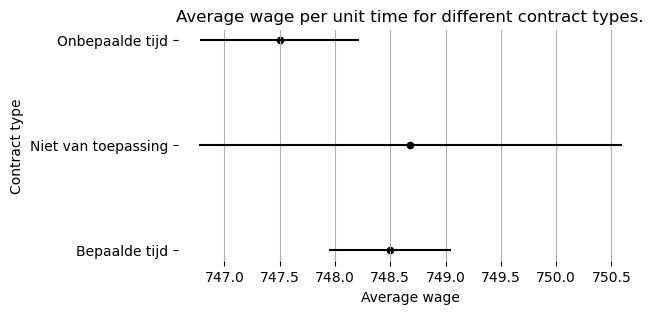

In [53]:
# One extra aggregation step because of the concatenation
result_agg = df_agg.groupby('SCONTRACTSOORT').sum()
result_agg.index = result_agg.index.map(meta.value_labels["labels1"])

# Compute the statistics we want
result_agg['mean'] = result_agg['sum'] / result_agg['n']
result_agg['var'] = result_agg['ssq'] / result_agg['n'] - (result_agg['sum'] / result_agg['n'])**2
result_agg['sd'] = np.sqrt(result_agg['var'])
result_agg['sem'] = result_agg['sd'] / np.sqrt(result_agg['n'])

# Create plot
fig, ax = plt.subplots(figsize=(6,3))

result_agg.reset_index().plot(
    y='SCONTRACTSOORT', x='mean', xerr=[1.96 * result_agg['sem'], 1.96 * result_agg['sem']],
    kind='scatter', ax=ax, color="k"
)

ax.set(
    ylabel='Contract type',
    xlabel='Average wage',
    title='Average wage per unit time for different contract types.'
)

plt.grid(axis="x")
sns.despine(left=True, bottom=True)
